In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


In [30]:
# Crear carpetas para resultados y figuras
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Cargar datos
data_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv'
data = pd.read_csv(data_path, sep=',')
print("Original data shape:", data.shape)

# Separar características y variable objetivo
X = data.drop(columns=['y'])
y = data['y']

# Definir columnas numéricas
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Escalar columnas numéricas
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])


Original data shape: (45211, 33)


In [31]:
# Selección de características con BorutaPy (on original data)
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X.values, y.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")
X = X[X_filtered]


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Selected features: 14


In [32]:
# Parámetros de la red neuronal
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
learning_rate = 0.0001
epochs = 50
n_iterations = 5
num_microbatches = 16
l2_norm_clip = 1.0

# Valores de parámetros a variar
noise_multiplier_values = [1.1, 1.5, 2.0, 2.5, 4, 6]
batch_size_values = [128, 64, 32, 16]
sample_size_ratios = [0.7, 0.8, 0.9, 1.0]

# Valores fijos por defecto
default_noise_multiplier = 1.1
default_batch_size = 16

In [33]:
# Función para calcular el presupuesto de privacidad
def compute_privacy_budget(n, batch_size, noise_multiplier, epochs, delta=1e-5):
    try:
        eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=n, batch_size=batch_size, noise_multiplier=noise_multiplier,
            epochs=epochs, delta=delta
        )[0]
        return eps
    except Exception as e:
        print(f"Error al calcular el presupuesto de privacidad: {e}")
        return float('inf')

# Definir la red neuronal con tf.keras
def create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=False,
                 num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
                 noise_multiplier=default_noise_multiplier):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Función para encontrar el umbral óptimo
def find_optimal_threshold(y_true, y_pred_prob):
    thresholds = np.arange(0.1, 0.9, 0.1)
    best_threshold = 0.5
    best_f1 = 0
    for t in thresholds:
        y_pred = (y_pred_prob > t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold

# Función para entrenar el modelo
def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=False,
                num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
                noise_multiplier=default_noise_multiplier):
    if use_dp and batch_size % num_microbatches != 0:
        raise ValueError(f"batch_size ({batch_size}) must be divisible by num_microbatches ({num_microbatches})")

    model = create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=use_dp,
                         num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
                         noise_multiplier=noise_multiplier)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    
    y_pred_prob_test = model.predict(X_test, batch_size=batch_size).flatten()
    optimal_threshold = 0.4 #find_optimal_threshold(y_test, y_pred_prob_test)
    print(f"Optimal threshold: {optimal_threshold:.2f}")
    y_pred_test = (y_pred_prob_test > optimal_threshold).astype(int)
    
    return y_pred_prob_test, y_pred_test

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_rate = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_rate = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': false_positive_rate,
        'Type II Error': false_negative_rate
    }

# Función para ejecutar múltiples iteraciones y calcular estadísticas
def run_iterations(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp, n_iterations,
                   num_microbatches, l2_norm_clip, noise_multiplier):
    results = []
    for _ in range(n_iterations):
        y_pred_prob_test, y_pred_test = train_model(
            X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=use_dp,
            num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier
        )
        result = evaluate_model(y_test, y_pred_test, y_pred_prob_test)
        results.append(result)
    return pd.DataFrame(results)

# Función para calcular estadísticas
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats

# Función para preparar datos con un tamaño de muestra específico
def prepare_data(X, y, sample_size_ratio, batch_size):
    if sample_size_ratio < 1.0:
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size_ratio, random_state=42, stratify=y)
    else:
        X_sample, y_sample = X, y

    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

    # Skip SMOTEENN as per previous recommendation
    X_train_filtered, y_train_filtered = X_train.values, y_train.values
    X_test_filtered, y_test_filtered = X_test.values, y_test.values

    return X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered, len(X_train_filtered)


In [34]:
# 1. Experimentos con tamaño de muestra completo (100%) como referencia
print("\n=== Experimentos con tamaño de muestra completo (100%) ===")
X_train_full, X_test_full, y_train_full, y_test_full, n_full = prepare_data(X, y, 1.0, default_batch_size)

# Entrenar modelo sin DP (baseline)
print("Entrenando modelo sin DP...")
results_no_dp = run_iterations(
    X_train_full, y_train_full, X_test_full, y_test_full,
    default_batch_size, epochs, use_dp=False, n_iterations=n_iterations,
    num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
    noise_multiplier=None
)
results_no_dp_stats = compute_statistics(results_no_dp)



=== Experimentos con tamaño de muestra completo (100%) ===
Entrenando modelo sin DP...
Epoch 1/50
2261/2261 [==============================] - 1s 569us/step - loss: 0.3574 - accuracy: 0.8769 - val_loss: 0.3129 - val_accuracy: 0.8843
Epoch 2/50
2261/2261 [==============================] - 1s 546us/step - loss: 0.3130 - accuracy: 0.8902 - val_loss: 0.2973 - val_accuracy: 0.8935
Epoch 3/50
2261/2261 [==============================] - 1s 536us/step - loss: 0.2973 - accuracy: 0.8928 - val_loss: 0.2853 - val_accuracy: 0.8945
Epoch 4/50
2261/2261 [==============================] - 1s 537us/step - loss: 0.2841 - accuracy: 0.8934 - val_loss: 0.2731 - val_accuracy: 0.8940
Epoch 5/50
2261/2261 [==============================] - 1s 539us/step - loss: 0.2694 - accuracy: 0.8946 - val_loss: 0.2602 - val_accuracy: 0.8956
Epoch 6/50
2261/2261 [==============================] - 1s 549us/step - loss: 0.2589 - accuracy: 0.8969 - val_loss: 0.2512 - val_accuracy: 0.8980
Epoch 7/50
2261/2261 [==============

In [35]:
# 2. Variar noise_multiplier
results_noise_multiplier = {}
eps_noise_multiplier = {}
for noise in noise_multiplier_values:
    print(f"\nEntrenando modelo con noise_multiplier={noise}...")
    eps = compute_privacy_budget(n_full, default_batch_size, noise, epochs)
    results = run_iterations(
        X_train_full, y_train_full, X_test_full, y_test_full,
        default_batch_size, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise
    )
    results_noise_multiplier[noise] = compute_statistics(results)
    eps_noise_multiplier[noise] = eps
    


Entrenando modelo con noise_multiplier=1.1...
DP-SGD with sampling rate = 0.0442% and noise_multiplier = 1.1 iterated over 113025 steps satisfies differential privacy with eps = 0.96 and delta = 1e-05.
The optimal RDP order is 18.0.
Epoch 1/50
2261/2261 [==============================] - 1s 508us/step - loss: 0.5370 - accuracy: 0.7778 - val_loss: 0.4235 - val_accuracy: 0.8831
Epoch 2/50
2261/2261 [==============================] - 1s 479us/step - loss: 0.4114 - accuracy: 0.8829 - val_loss: 0.4008 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 481us/step - loss: 0.4011 - accuracy: 0.8830 - val_loss: 0.3961 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 483us/step - loss: 0.3987 - accuracy: 0.8830 - val_loss: 0.3929 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 482us/step - loss: 0.3944 - accuracy: 0.8830 - val_loss: 0.3901 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 495us/step - loss: 0.4193 - accuracy: 0.8792 - val_loss: 0.3899 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 479us/step - loss: 0.3964 - accuracy: 0.8829 - val_loss: 0.3861 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 481us/step - loss: 0.3938 - accuracy: 0.8830 - val_loss: 0.3832 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 484us/step - loss: 0.3894 - accuracy: 0.8829 - val_loss: 0.3806 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 482us/step - loss: 0.3865 - accuracy: 0.8830 - val_loss: 0.3781 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 519us/step - loss: 0.3835 - accuracy: 0.8830 - val_loss: 0.3758 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 485us/step - loss: 0.3818 - accuracy: 0.8830 - val_loss: 0.3737 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 596us/step - loss: 0.4115 - accuracy: 0.8808 - val_loss: 0.3770 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 580us/step - loss: 0.3809 - accuracy: 0.8830 - val_loss: 0.3733 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 597us/step - loss: 0.3798 - accuracy: 0.8830 - val_loss: 0.3705 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 582us/step - loss: 0.3758 - accuracy: 0.8830 - val_loss: 0.3679 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 582us/step - loss: 0.3738 - accuracy: 0.8830 - val_loss: 0.3655 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 575us/step - loss: 0.3718 - accuracy: 0.8830 - val_loss: 0.3632 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 572us/step - loss: 0.3696 - accuracy: 0.8830 - val_loss: 0.3609 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 603us/step - loss: 0.4510 - accuracy: 0.8551 - val_loss: 0.3901 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 599us/step - loss: 0.3987 - accuracy: 0.8827 - val_loss: 0.3843 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 596us/step - loss: 0.3933 - accuracy: 0.8827 - val_loss: 0.3810 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 599us/step - loss: 0.3893 - accuracy: 0.8830 - val_loss: 0.3782 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 631us/step - loss: 0.3875 - accuracy: 0.8829 - val_loss: 0.3755 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 592us/step - loss: 0.3828 - accuracy: 0.8830 - val_loss: 0.3732 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 595us/step - loss: 0.3807 - accuracy: 0.8830 - val_loss: 0.3707 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 516us/step - loss: 0.4055 - accuracy: 0.8830 - val_loss: 0.3939 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 485us/step - loss: 0.3994 - accuracy: 0.8830 - val_loss: 0.3912 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 536us/step - loss: 0.3962 - accuracy: 0.8829 - val_loss: 0.3889 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 502us/step - loss: 0.3944 - accuracy: 0.8830 - val_loss: 0.3867 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 497us/step - loss: 0.3927 - accuracy: 0.8830 - val_loss: 0.3848 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 501us/step - loss: 0.3895 - accuracy: 0.8830 - val_loss: 0.3829 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 504us/step - loss: 0.3892 - accuracy: 0.8830 - val_loss: 0.3811 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 584us/step - loss: 0.4170 - accuracy: 0.8805 - val_loss: 0.3785 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 556us/step - loss: 0.3833 - accuracy: 0.8830 - val_loss: 0.3741 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 565us/step - loss: 0.3785 - accuracy: 0.8830 - val_loss: 0.3719 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 567us/step - loss: 0.3766 - accuracy: 0.8830 - val_loss: 0.3698 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 573us/step - loss: 0.3745 - accuracy: 0.8830 - val_loss: 0.3677 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 566us/step - loss: 0.3737 - accuracy: 0.8830 - val_loss: 0.3658 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 568us/step - loss: 0.3712 - accuracy: 0.8830 - val_loss: 0.3640 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 495us/step - loss: 0.4577 - accuracy: 0.8673 - val_loss: 0.3878 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 475us/step - loss: 0.3848 - accuracy: 0.8830 - val_loss: 0.3756 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 508us/step - loss: 0.3787 - accuracy: 0.8830 - val_loss: 0.3722 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 483us/step - loss: 0.3749 - accuracy: 0.8830 - val_loss: 0.3699 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 490us/step - loss: 0.3741 - accuracy: 0.8830 - val_loss: 0.3679 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 488us/step - loss: 0.3734 - accuracy: 0.8830 - val_loss: 0.3662 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 482us/step - loss: 0.3707 - accuracy: 0.8830 - val_loss: 0.3647 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 511us/step - loss: 0.5219 - accuracy: 0.7713 - val_loss: 0.3863 - val_accuracy: 0.8829
Epoch 2/50
2261/2261 [==============================] - 1s 489us/step - loss: 0.3905 - accuracy: 0.8829 - val_loss: 0.3759 - val_accuracy: 0.8829
Epoch 3/50
2261/2261 [==============================] - 1s 489us/step - loss: 0.3838 - accuracy: 0.8830 - val_loss: 0.3730 - val_accuracy: 0.8829
Epoch 4/50
2261/2261 [==============================] - 1s 488us/step - loss: 0.3819 - accuracy: 0.8830 - val_loss: 0.3704 - val_accuracy: 0.8829
Epoch 5/50
2261/2261 [==============================] - 1s 491us/step - loss: 0.3783 - accuracy: 0.8831 - val_loss: 0.3680 - val_accuracy: 0.8829
Epoch 6/50
2261/2261 [==============================] - 1s 502us/step - loss: 0.3753 - accuracy: 0.8830 - val_loss: 0.3656 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 492us/step - loss: 0.3730 - accuracy: 0.8831 - val_loss: 0.3633 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 576us/step - loss: 0.4524 - accuracy: 0.8544 - val_loss: 0.3845 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 2s 718us/step - loss: 0.3937 - accuracy: 0.8829 - val_loss: 0.3797 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 2s 814us/step - loss: 0.3904 - accuracy: 0.8830 - val_loss: 0.3767 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 2s 851us/step - loss: 0.3866 - accuracy: 0.8830 - val_loss: 0.3737 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 2s 915us/step - loss: 0.3813 - accuracy: 0.8830 - val_loss: 0.3710 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 2s 759us/step - loss: 0.3778 - accuracy: 0.8830 - val_loss: 0.3682 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 605us/step - loss: 0.3751 - accuracy: 0.8830 - val_loss: 0.3658 - val_accura

In [36]:
# 3. Variar batch_size
results_batch_size = {}
eps_batch_size = {}
for bs in batch_size_values:
    print(f"\nEntrenando modelo con batch_size={bs}...")
    eps = compute_privacy_budget(n_full, bs, default_noise_multiplier, epochs)
    results = run_iterations(
        X_train_full, y_train_full, X_test_full, y_test_full,
        bs, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
        noise_multiplier=default_noise_multiplier
    )
    results_batch_size[bs] = compute_statistics(results)
    eps_batch_size[bs] = eps
    


Entrenando modelo con batch_size=128...
DP-SGD with sampling rate = 0.354% and noise_multiplier = 1.1 iterated over 14129 steps satisfies differential privacy with eps = 2.48 and delta = 1e-05.
The optimal RDP order is 10.0.
Epoch 1/50
283/283 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8830 - val_loss: 0.4071 - val_accuracy: 0.8830
Epoch 2/50
283/283 [==============================] - 0s 880us/step - loss: 0.4111 - accuracy: 0.8830 - val_loss: 0.4035 - val_accuracy: 0.8830
Epoch 3/50
283/283 [==============================] - 0s 865us/step - loss: 0.4080 - accuracy: 0.8830 - val_loss: 0.4011 - val_accuracy: 0.8830
Epoch 4/50
283/283 [==============================] - 0s 862us/step - loss: 0.4046 - accuracy: 0.8830 - val_loss: 0.3994 - val_accuracy: 0.8830
Epoch 5/50
283/283 [==============================] - 0s 936us/step - loss: 0.4016 - accuracy: 0.8830 - val_loss: 0.3981 - val_accuracy: 0.8830
Epoch 6/50
283/283 [==============================] - 0s

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


566/566 [==============================] - 1s 950us/step - loss: 0.6779 - accuracy: 0.6139 - val_loss: 0.4443 - val_accuracy: 0.8825
Epoch 2/50
566/566 [==============================] - 0s 735us/step - loss: 0.4377 - accuracy: 0.8673 - val_loss: 0.3990 - val_accuracy: 0.8830
Epoch 3/50
566/566 [==============================] - 0s 695us/step - loss: 0.4097 - accuracy: 0.8796 - val_loss: 0.3911 - val_accuracy: 0.8830
Epoch 4/50
566/566 [==============================] - 0s 725us/step - loss: 0.4063 - accuracy: 0.8809 - val_loss: 0.3887 - val_accuracy: 0.8830
Epoch 5/50
566/566 [==============================] - 0s 675us/step - loss: 0.4022 - accuracy: 0.8815 - val_loss: 0.3874 - val_accuracy: 0.8830
Epoch 6/50
566/566 [==============================] - 0s 667us/step - loss: 0.4013 - accuracy: 0.8822 - val_loss: 0.3863 - val_accuracy: 0.8830
Epoch 7/50
566/566 [==============================] - 0s 687us/step - loss: 0.3997 - accuracy: 0.8819 - val_loss: 0.3852 - val_accuracy: 0.8830
Epo

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1131/1131 [==============================] - 1s 568us/step - loss: 0.5145 - accuracy: 0.8073 - val_loss: 0.4147 - val_accuracy: 0.8825
Epoch 2/50
1131/1131 [==============================] - 1s 510us/step - loss: 0.4081 - accuracy: 0.8819 - val_loss: 0.3912 - val_accuracy: 0.8830
Epoch 3/50
1131/1131 [==============================] - 1s 522us/step - loss: 0.3964 - accuracy: 0.8828 - val_loss: 0.3861 - val_accuracy: 0.8830
Epoch 4/50
1131/1131 [==============================] - 1s 543us/step - loss: 0.3921 - accuracy: 0.8830 - val_loss: 0.3837 - val_accuracy: 0.8830
Epoch 5/50
1131/1131 [==============================] - 1s 687us/step - loss: 0.3889 - accuracy: 0.8830 - val_loss: 0.3820 - val_accuracy: 0.8830
Epoch 6/50
1131/1131 [==============================] - 1s 557us/step - loss: 0.3894 - accuracy: 0.8830 - val_loss: 0.3806 - val_accuracy: 0.8830
Epoch 7/50
1131/1131 [==============================] - 1s 596us/step - loss: 0.3872 - accuracy: 0.8830 - val_loss: 0.3793 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1131/1131 [==============================] - 1s 588us/step - loss: 0.4354 - accuracy: 0.8761 - val_loss: 0.3937 - val_accuracy: 0.8830
Epoch 2/50
1131/1131 [==============================] - 1s 509us/step - loss: 0.3993 - accuracy: 0.8825 - val_loss: 0.3824 - val_accuracy: 0.8830
Epoch 3/50
1131/1131 [==============================] - 1s 516us/step - loss: 0.3908 - accuracy: 0.8829 - val_loss: 0.3792 - val_accuracy: 0.8830
Epoch 4/50
1131/1131 [==============================] - 1s 514us/step - loss: 0.3879 - accuracy: 0.8829 - val_loss: 0.3773 - val_accuracy: 0.8830
Epoch 5/50
1131/1131 [==============================] - 1s 620us/step - loss: 0.3860 - accuracy: 0.8829 - val_loss: 0.3756 - val_accuracy: 0.8830
Epoch 6/50
1131/1131 [==============================] - 1s 529us/step - loss: 0.3831 - accuracy: 0.8829 - val_loss: 0.3740 - val_accuracy: 0.8830
Epoch 7/50
1131/1131 [==============================] - 1s 729us/step - loss: 0.3820 - accuracy: 0.8829 - val_loss: 0.3724 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
2261/2261 [==============================] - 2s 723us/step - loss: 0.4949 - accuracy: 0.8033 - val_loss: 0.4018 - val_accuracy: 0.8815
Epoch 2/50
2261/2261 [==============================] - 1s 582us/step - loss: 0.4004 - accuracy: 0.8809 - val_loss: 0.3918 - val_accuracy: 0.8830
Epoch 3/50
2261/2261 [==============================] - 1s 548us/step - loss: 0.3931 - accuracy: 0.8824 - val_loss: 0.3878 - val_accuracy: 0.8830
Epoch 4/50
2261/2261 [==============================] - 1s 528us/step - loss: 0.3915 - accuracy: 0.8826 - val_loss: 0.3842 - val_accuracy: 0.8830
Epoch 5/50
2261/2261 [==============================] - 1s 523us/step - loss: 0.3880 - accuracy: 0.8828 - val_loss: 0.3807 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 594us/step - loss: 0.3834 - accuracy: 0.8828 - val_loss: 0.3776 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 544us/step - loss: 0.3813 - accuracy: 0.8829 - val_loss: 0.3746 -

In [37]:
# 4. Variar tamaño de muestra
results_sample_size = {}
eps_sample_size = {}
for ratio in sample_size_ratios:
    print(f"\n=== Experimentos con tamaño de muestra {ratio*100}% ===")
    X_train_ss, X_test_ss, y_train_ss, y_test_ss, n_ss = prepare_data(X, y, ratio, default_batch_size)
    print(f"Training set size: {n_ss}")
    eps = compute_privacy_budget(n_ss, default_batch_size, default_noise_multiplier, epochs)
    results = run_iterations(
        X_train_ss, y_train_ss, X_test_ss, y_test_ss,
        default_batch_size, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
        noise_multiplier=default_noise_multiplier
    )
    results_sample_size[ratio] = compute_statistics(results)
    eps_sample_size[ratio] = eps



=== Experimentos con tamaño de muestra 70.0% ===
Training set size: 25317
DP-SGD with sampling rate = 0.0632% and noise_multiplier = 1.1 iterated over 79116 steps satisfies differential privacy with eps = 1.08 and delta = 1e-05.
The optimal RDP order is 17.0.
Epoch 1/50
1583/1583 [==============================] - 1s 558us/step - loss: 0.4948 - accuracy: 0.8234 - val_loss: 0.3933 - val_accuracy: 0.8831
Epoch 2/50
1583/1583 [==============================] - 1s 481us/step - loss: 0.3965 - accuracy: 0.8828 - val_loss: 0.3787 - val_accuracy: 0.8831
Epoch 3/50
1583/1583 [==============================] - 1s 504us/step - loss: 0.3920 - accuracy: 0.8829 - val_loss: 0.3753 - val_accuracy: 0.8831
Epoch 4/50
1583/1583 [==============================] - 1s 554us/step - loss: 0.3866 - accuracy: 0.8830 - val_loss: 0.3729 - val_accuracy: 0.8831
Epoch 5/50
1583/1583 [==============================] - 1s 494us/step - loss: 0.3841 - accuracy: 0.8828 - val_loss: 0.3708 - val_accuracy: 0.8831
Epoch 6/5

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1583/1583 [==============================] - 1s 647us/step - loss: 0.4507 - accuracy: 0.8618 - val_loss: 0.3893 - val_accuracy: 0.8831
Epoch 2/50
1583/1583 [==============================] - 1s 548us/step - loss: 0.3977 - accuracy: 0.8829 - val_loss: 0.3822 - val_accuracy: 0.8831
Epoch 3/50
1583/1583 [==============================] - 1s 562us/step - loss: 0.3942 - accuracy: 0.8829 - val_loss: 0.3790 - val_accuracy: 0.8831
Epoch 4/50
1583/1583 [==============================] - 1s 767us/step - loss: 0.3912 - accuracy: 0.8830 - val_loss: 0.3764 - val_accuracy: 0.8831
Epoch 5/50
1583/1583 [==============================] - 1s 537us/step - loss: 0.3880 - accuracy: 0.8829 - val_loss: 0.3741 - val_accuracy: 0.8831
Epoch 6/50
1583/1583 [==============================] - 1s 506us/step - loss: 0.3858 - accuracy: 0.8830 - val_loss: 0.3718 - val_accuracy: 0.8831
Epoch 7/50
1583/1583 [==============================] - 1s 551us/step - loss: 0.3820 - accuracy: 0.8828 - val_loss: 0.3697 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1809/1809 [==============================] - 1s 532us/step - loss: 0.4414 - accuracy: 0.8766 - val_loss: 0.4021 - val_accuracy: 0.8831
Epoch 2/50
1809/1809 [==============================] - 1s 493us/step - loss: 0.4102 - accuracy: 0.8830 - val_loss: 0.3945 - val_accuracy: 0.8831
Epoch 3/50
1809/1809 [==============================] - 1s 489us/step - loss: 0.4042 - accuracy: 0.8830 - val_loss: 0.3907 - val_accuracy: 0.8831
Epoch 4/50
1809/1809 [==============================] - 1s 487us/step - loss: 0.3991 - accuracy: 0.8829 - val_loss: 0.3879 - val_accuracy: 0.8831
Epoch 5/50
1809/1809 [==============================] - 1s 489us/step - loss: 0.3969 - accuracy: 0.8829 - val_loss: 0.3857 - val_accuracy: 0.8831
Epoch 6/50
1809/1809 [==============================] - 1s 504us/step - loss: 0.3953 - accuracy: 0.8829 - val_loss: 0.3836 - val_accuracy: 0.8831
Epoch 7/50
1809/1809 [==============================] - 1s 492us/step - loss: 0.3934 - accuracy: 0.8830 - val_loss: 0.3815 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2261/2261 [==============================] - 1s 536us/step - loss: 0.4233 - accuracy: 0.8747 - val_loss: 0.3898 - val_accuracy: 0.8830
Epoch 2/50
2261/2261 [==============================] - 1s 505us/step - loss: 0.3953 - accuracy: 0.8826 - val_loss: 0.3864 - val_accuracy: 0.8829
Epoch 3/50
2261/2261 [==============================] - 1s 503us/step - loss: 0.3915 - accuracy: 0.8827 - val_loss: 0.3833 - val_accuracy: 0.8829
Epoch 4/50
2261/2261 [==============================] - 1s 505us/step - loss: 0.3874 - accuracy: 0.8828 - val_loss: 0.3803 - val_accuracy: 0.8829
Epoch 5/50
2261/2261 [==============================] - 1s 500us/step - loss: 0.3852 - accuracy: 0.8831 - val_loss: 0.3775 - val_accuracy: 0.8830
Epoch 6/50
2261/2261 [==============================] - 1s 499us/step - loss: 0.3816 - accuracy: 0.8829 - val_loss: 0.3749 - val_accuracy: 0.8830
Epoch 7/50
2261/2261 [==============================] - 1s 522us/step - loss: 0.3793 - accuracy: 0.8830 - val_loss: 0.3727 - val_accura

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Guardar resultados en un CSV
results_stats = {
    'noise_multiplier': results_noise_multiplier,
    'batch_size': results_batch_size,
    'sample_size': results_sample_size
}
data = {}
for param, stats_dict in results_stats.items():
    for value, stats in stats_dict.items():
        if param == 'sample_size':
            model = f'{param}={value*100}% (ε={eps_sample_size[value]:.2f})'
        else:
            model = f'{param}={value} (ε={eps_noise_multiplier.get(value, eps_batch_size.get(value, 0)):.2f})'
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']
results_df = pd.DataFrame(data).round(4)
results_df.to_csv('results/CDP_parameter_results_updated.csv')
print("\nResultados guardados en 'results/CDP_parameter_results_updated.csv'")
print("\nResultados (Promedios):\n", results_df[[col for col in results_df.columns if 'mean' in col]])




Resultados guardados en 'results/CDP_parameter_results_updated.csv'

Resultados (Promedios):
                noise_multiplier=1.1 (ε=0.96) (mean)  \
ROC AUC                                      0.7218   
Accuracy                                     0.8845   
Precision                                    0.4345   
Recall                                       0.0208   
F1 Score                                     0.0387   
Type I Error                                 0.0010   
Type II Error                                0.9792   

               noise_multiplier=1.5 (ε=0.57) (mean)  \
ROC AUC                                      0.7218   
Accuracy                                     0.8845   
Precision                                    0.4810   
Recall                                       0.0210   
F1 Score                                     0.0383   
Type I Error                                 0.0011   
Type II Error                                0.9790   

               noise_mu

In [39]:
# Función para graficar resultados, incluyendo el modelo sin DP
def plot_parameter_results(stats_dict, eps_dict, param_name, colors, no_dp_stats):
    metrics = list(no_dp_stats['mean'].keys())  # All metrics: ROC AUC, Accuracy, Precision, Recall, F1 Score, Type I Error, Type II Error
    values = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_values = len(values) + 1  # +1 for No DP
    
    plt.figure(figsize=(12, 6))  # Increased width to accommodate all metrics
    x_positions = np.arange(n_metrics) * 1.3  # Space out the metrics for clarity
    
    # No DP
    means = [no_dp_stats['mean'][metric] for metric in metrics]
    mins = [no_dp_stats['min'][metric] for metric in metrics]
    maxs = [no_dp_stats['max'][metric] for metric in metrics]
    plt.scatter(x_positions + (0 - (n_values-1)/2) * 0.15, means, 
                color=colors[0], label='No DP', s=100)
    for metric_idx in range(n_metrics):
        plt.vlines(x_positions[metric_idx] + (0 - (n_values-1)/2) * 0.15, 
                   mins[metric_idx], maxs[metric_idx], 
                   color=colors[0], linestyle='-', linewidth=1)
    
    # DP models
    for value_idx, value in enumerate(values, start=1):
        means = [stats_dict[value]['mean'][metric] for metric in metrics]
        mins = [stats_dict[value]['min'][metric] for metric in metrics]
        maxs = [stats_dict[value]['max'][metric] for metric in metrics]
        if param_name == 'sample_size':
            label = f'{param_name}={value*100}% (ε={eps_dict[value]:.2f})'
        else:
            label = f'{param_name}={value} (ε={eps_dict[value]:.2f})'
        plt.scatter(x_positions + (value_idx - (n_values-1)/2) * 0.15, means, 
                    color=colors[value_idx], label=label, s=100)
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (value_idx - (n_values-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[value_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45, ha='right', fontsize=10)
    plt.title(f'Effect of Varying {param_name} on Model Performance', fontsize=14)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(title=f'{param_name} Values', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'figures/Effect_of_{param_name}_All_Metrics.jpg', dpi=300, bbox_inches='tight')
    plt.show()

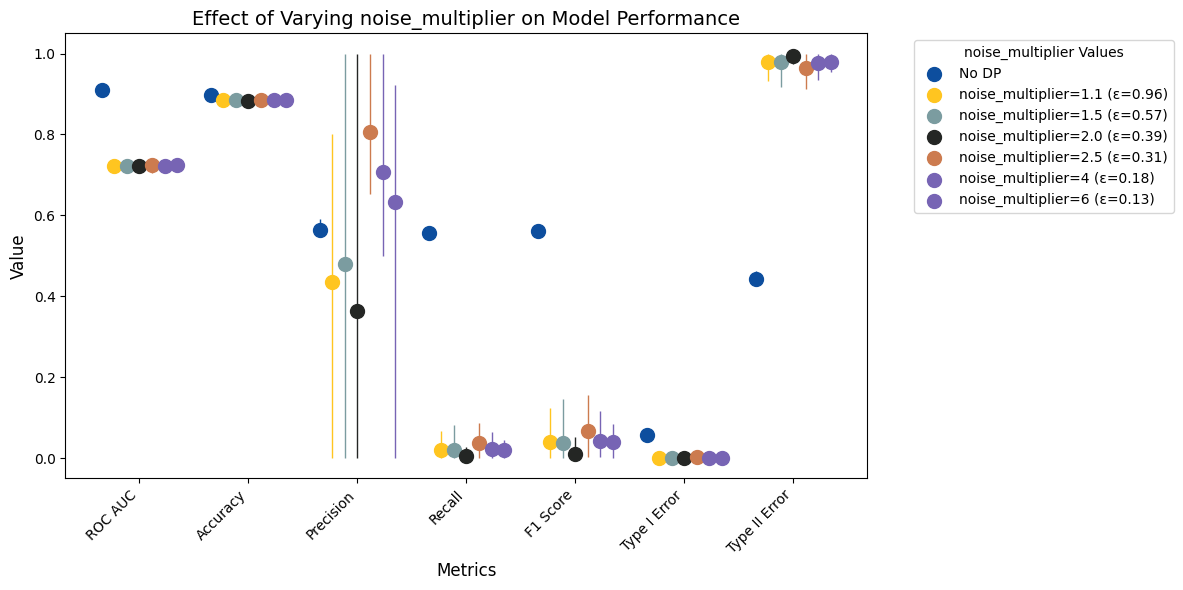

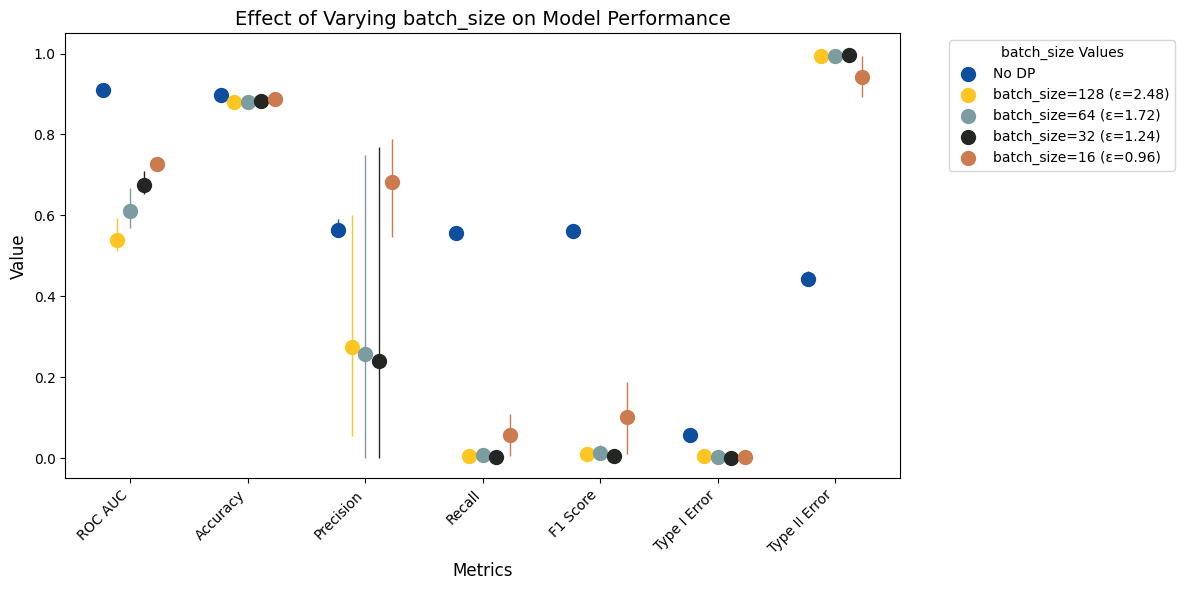

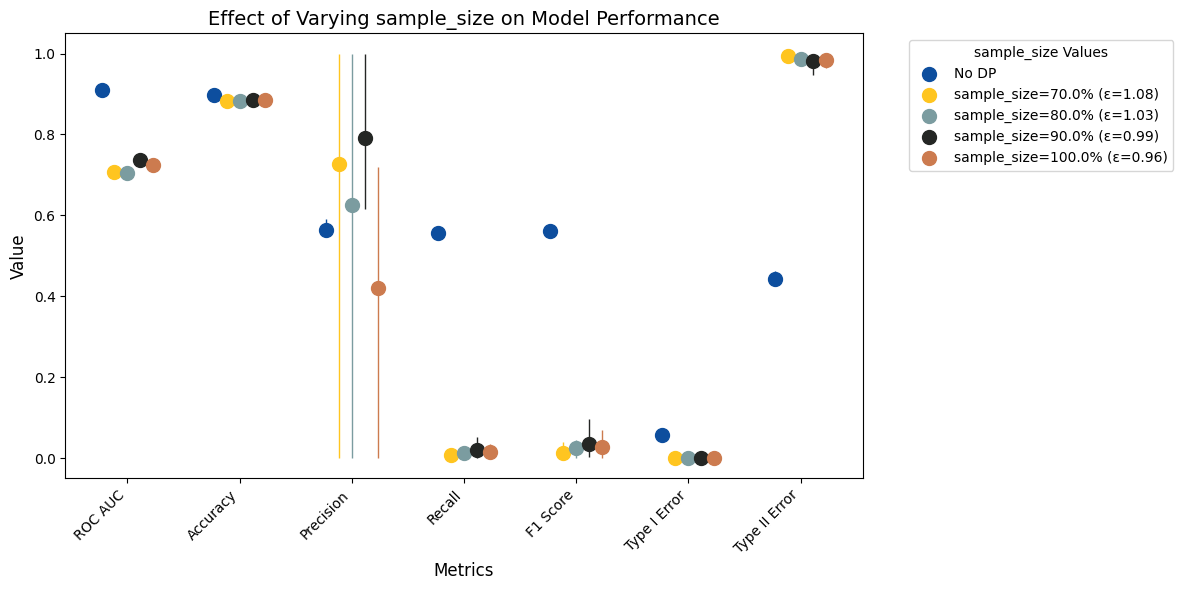

In [40]:
# Definir colores para cada valor de los parámetros
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f', '#7764B4','#7764B4']

# Graficar resultados para cada parámetro
plot_parameter_results(results_noise_multiplier, eps_noise_multiplier, 'noise_multiplier', colors, results_no_dp_stats)
plot_parameter_results(results_batch_size, eps_batch_size, 'batch_size', colors, results_no_dp_stats)
plot_parameter_results(results_sample_size, eps_sample_size, 'sample_size', colors, results_no_dp_stats)